In [1]:
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.externals import joblib
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
np.set_printoptions(suppress= True)

In [18]:
def gen_sample(data, idx):
    '''
    生成labels和预测所需的特征
    param : data : dataframe of samples
    param : idx : begining time to predict
    return1 : last true aqi
    return2 : true aqis
    return3 : list of features
    '''
    if len(data) - 9 < idx:
        return None
    lastAqi = data.iloc[idx,1]
    trueAqis = data.iloc[idx:idx + 8,0].values
    features = data.iloc[idx:idx + 8,2:].values
    
    return lastAqi, trueAqis, features

In [69]:
def pre_8(model, features, aqi_last):
    '''
    预测后面8个时次的aqi
    param : model : model to use
    param : features : list of features
    param : aqi_last : first aqi needed to pass
    return: list of aqi_pred
    '''
    aqis = [aqi_last]
    for f in features:
        f = np.r_[aqis[-1], f].reshape(1,-1)
        aqi = model.predict(f)
        aqis.append(aqi[0])
    return aqis[1:]

In [103]:
def interp(aqis):
    '''
    将8个时次的aqi插值为24个时次
    param : aqis : list of aqi_pred or true
    return: list of aqis(24)
    '''
    aqis_24 = np.interp(np.arange(0,24),[0,3,6,9,12,15,18,21], aqis)
    return aqis_24.round(2).tolist()

In [105]:
def runOnetime(data, model, idx):
    '''
    反演一个时刻的aqi
    param : model : model to use
    param : data : dataframe of samples
    param : idx : begining time to predict
    return1 : true aqis_24
    return2 : pred aqis_24
    '''
    lastAqi, trueAqis, features = gen_sample(data,idx)
    predAqis_8 = pre_8(model, features, lastAqi)
    trueAqis_24 = interp(trueAqis)
    predAqis_24 = interp(predAqis_8)
    return trueAqis_24, predAqis_24

In [126]:
def visualize():
    fig = plt.figure(0,(16,12))
    h = [0,6,12,18]
    for i, t in enumerate(h):
        ax = plt.subplot(2,2,i+1)
        ax.scatter(predAqis_24_all[:,t],trueAqis_24_all[:,t], c = 'k', marker= '.', alpha= 0.5)
        ax.plot([0,500],[0,500],'r-')
        ax.set_xlabel('pred aqi')
        ax.set_ylabel('true aqi')
        r = np.corrcoef(predAqis_24_all[:,t],trueAqis_24_all[:,t])[0,1]
        ax.set_title('AQI pred vs true({:02d}h) \nr = {:.2f}'.format(t ,r))
    plt.tight_layout(1.10)
    plt.savefig('figure/pre_24.jpg')
    plt.show()

In [110]:
if __name__ == '__main__':
    sample = pd.read_csv('aqi/sample.csv')
    model_aqi = joblib.load('model/model_aqi1')
    
    trueAqis_24_all = []
    predAqis_24_all = []
    
    for i in range(len(sample) - 9):
        trueAqis_24, predAqis_24 = runOnetime(sample,model_aqi,i)
        trueAqis_24_all.append(trueAqis_24)
        predAqis_24_all.append(predAqis_24)
        
    trueAqis_24_all = np.array(trueAqis_24_all)
    predAqis_24_all = np.array(predAqis_24_all)
    visualize()

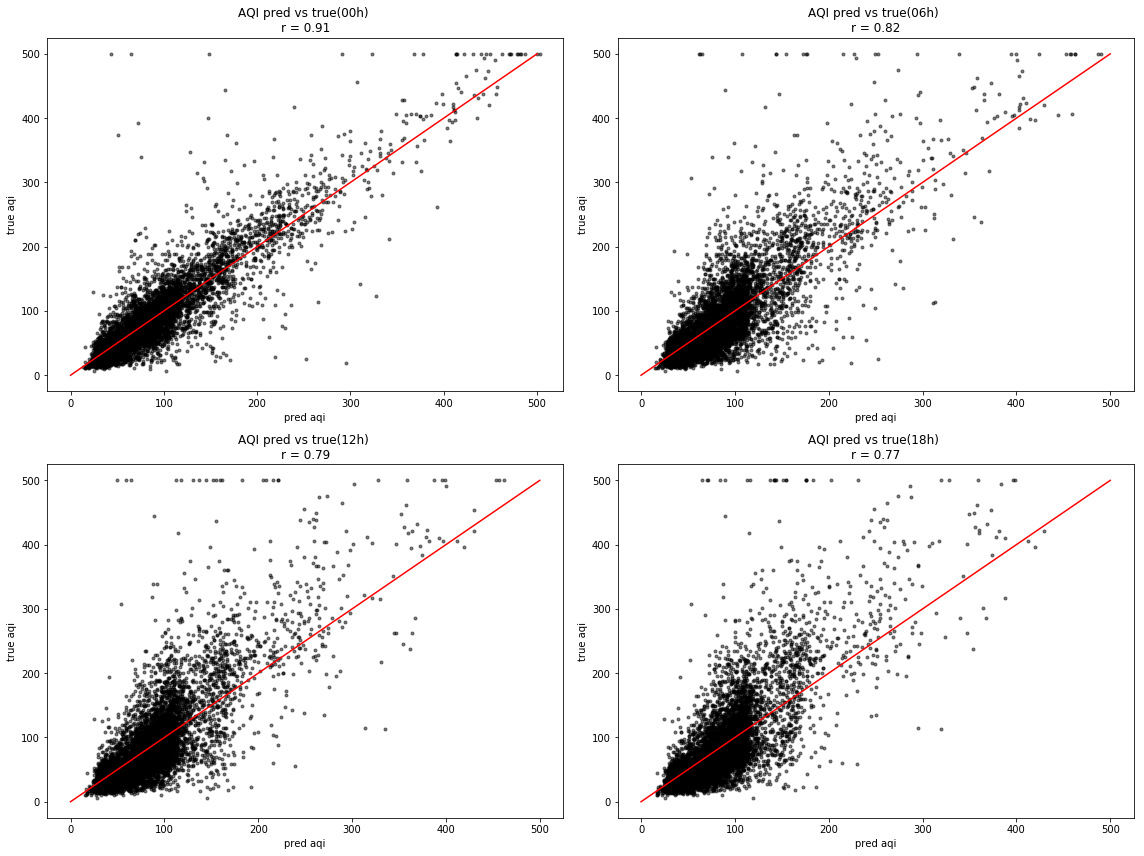

In [125]:
visualize()